**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
import re
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import TfidfTransformer
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [2]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors=5, algorithm='brute', metric='euclidean'):
        self.k = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        if self.algorithm == 'brute':
            self.X = X
        elif self.algorithm == 'kd_tree':
            self.kd_tree = KDTree(X, leaf_size=1)
        else:
            raise ValueError("internal: _fit_method not recognized")
        self.y = y

    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1).astype(int)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            dist = pairwise_distances(X=X, Y=self.X, metric=self.metric)
            neighbors = np.argpartition(dist, self.k)[:, :self.k].astype(int)
        elif self.algorithm == 'kd_tree':
            _, neighbors = self.kd_tree.query(X, k=self.k)
        else:
            raise ValueError("internal: _fit_method not recognized")
        arr = self.y[neighbors]
        return np.apply_along_axis(np.bincount, axis=1, arr=arr,
                                   minlength=np.max(arr) + 1) / self.k

    def score(self, X, y):
        return np.average(self.predict(X) == y)

    def best_k(self, X, y, n_splits=3):
        scores = self.scores(X, y, 10, n_splits)
        self.k = scores.argmax()
        return self.k

    def scores(self, X, y, max_k, n_splits=3):
        kf = KFold(n_splits, shuffle=True)
        max_k = 10
        scores = np.zeros(shape=(max_k + 1, n_splits))
        for j in range(1, max_k + 1):
            self.k = j
            i = 0
            for train, test in kf.split(X):
                X_train, X_test = X[train], X[test]
                y_train, y_test = y[train], y[test]
                self.fit(X_train, y_train)
                scores[j][i] = self.score(X_test, y_test)
                i += 1
        return scores.mean(axis=1)


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test)) <0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 1.99 ms


array([1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 1, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 1, 2])

In [12]:
%time clf.predict_proba(X_test)

Wall time: 1e+03 µs


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 2.06 ms


array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

Wall time: 1.41 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [18]:
%time clf.predict(X_test)

Wall time: 5 ms


array([2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2])

In [19]:
%time my_clf.predict(X_test)

Wall time: 0 ns


array([2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2])

In [20]:
%time clf.predict_proba(X_test)

Wall time: 0 ns


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [21]:
%time my_clf.predict_proba(X_test)

Wall time: 0 ns


array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [25]:
data_tok = [re.sub('\W+',' ', data[i]).lower().split() for i in range(len(data))]
target = list(target)
i = 0
while i < len(data_tok):
    if not len(data_tok[i]):
        data_tok.pop(i)
        target.pop(i)
    else:
        i += 1
target = np.asarray(target)

In [26]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"


Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [27]:
word_map = {}
for data in data_tok:
    for word in data:
        word_map[word] = word_map.get(word, len(word_map))
w_counts = lil_matrix((len(data_tok), len(word_map)), dtype=int)
for i in range(len(data_tok)):
    for word in data_tok[i]:
        w_counts[i, word_map[word]] += 1
w_counts = w_counts.tocsr()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [28]:
my_clf = MyKNeighborsClassifier(n_neighbors=7, algorithm='brute')
clf = KNeighborsClassifier(n_neighbors=7, algorithm='brute')
kf = KFold(n_splits=3, shuffle=True)
for train, test in kf.split(w_counts):
    print("%s %s" % (train, test))
    X_train, X_test, y_train, y_test = w_counts[train], w_counts[test], target[train], target[test]
    my_clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    print(my_clf.score(X_test, y_test), clf.score(X_test, y_test))

[    0     1     2 ... 11001 11002 11003] [   14    16    21 ... 10987 10988 10989]
0.20365321701199562 0.20365321701199562
[    1     2     3 ... 10998 10999 11000] [    0     4     8 ... 11001 11002 11003]
0.1971101417666303 0.1971101417666303
[    0     4     8 ... 11001 11002 11003] [    1     2     3 ... 10998 10999 11000]
0.19738276990185388 0.19738276990185388


In [29]:
my_clf.best_k(w_counts, target, 10)

1

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [30]:
trans_w_counts = TfidfTransformer().fit_transform(w_counts)
scores00 = my_clf.scores(w_counts, target, 10)
scores01 = my_clf.scores(trans_w_counts, target, 10)
my_clf = MyKNeighborsClassifier(algorithm='brute', metric='cosine')
scores10 = my_clf.scores(w_counts, target, 10)
scores11 = my_clf.scores(trans_w_counts, target, 10)

Euclidean transformed: 0.6007815339876409
Cosine transformed: 0.5976008724100327


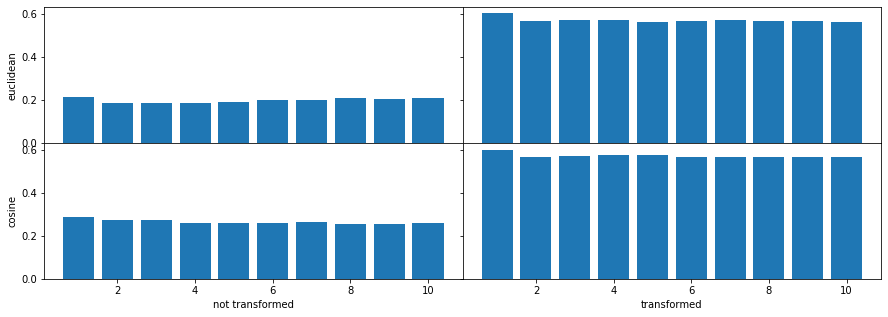

In [31]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.0, hspace=0.0)
axes[0, 0].set_ylabel('euclidean')
axes[1, 0].set_ylabel('cosine')
axes[1, 0].set_xlabel('not transformed')
axes[1, 1].set_xlabel('transformed')
axes[0, 0].bar(range(1, 11), scores00[1:11])
axes[1, 0].bar(range(1, 11), scores10[1:11])
axes[0, 1].bar(range(1, 11), scores01[1:11])
axes[1, 1].bar(range(1, 11), scores11[1:11])
print("Euclidean transformed:", scores01[1])
print("Cosine transformed:", scores11[1])

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [32]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']
test_data_tok = [re.sub('\W+',' ', test_data[i]).lower().split() for i in range(len(test_data))]
test_target = list(test_target)
i = 0
while i < len(test_data_tok):
    if not len(test_data_tok[i]):
        test_data_tok.pop(i)
        test_target.pop(i)
    else:
        i += 1
test_target = np.asarray(test_target)
test_w_counts = lil_matrix((len(test_data_tok), len(word_map)), dtype=int)
for i in range(len(test_data_tok)):
    for word in test_data_tok[i]:
        if (word_map.get(word, len(word_map)) < len(word_map)):
            test_w_counts[i, word_map[word]] += 1
test_w_counts = test_w_counts.tocsr()
trans_test_w_counts = TfidfTransformer().fit_transform(test_w_counts)

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [33]:
my_clf = MyKNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='euclidean')
my_clf.fit(trans_w_counts, target)
my_clf.score(trans_test_w_counts, test_target)

0.5126556300451498